# Socioeconomic scores : Area deprivation index (ADI)

Area deprivation index (ADI): Is a composite index that ranks neighborhoods by socioeconomic disadvantage in a specific region of interest (state or national level). It was developed by the University of Wisconsin-Madison.

    - The composite index is calculated with different inputs such as income, education, employment, and housing quality.
    - It is originally aggregated at the Census block group level (neighborhood unit), but has a mapping file for zip codes.
    - At the national level, the ADI scores are expressed as percentiles (1-100).
    - At the state level, the ADI scores are expressed as deciles (1-10), where 1 represents the least disadvantaged neighborhoods, while 10 are the most disadvantaged neighborhood. 
 
 
You can find more information about the ADI here: https://www.neighborhoodatlas.medicine.wisc.edu/

### 1. Loading ADI dataset

We downloaded previously the ADI dataset for Wisconsin state only from https://www.neighborhoodatlas.medicine.wisc.edu/ and exported to a csv file. Each column represents:
- ZIP_4: The 9 digit zip code ID 
- FIPS: The block group Census ID
- GISJOIN: Key linkage field to the block group shapefile served by NHGIS
- ADI_NATRANK: National percentile of block group ADI score
- ADI_STATERNK: State-specific decile of block group ADI score

In [1]:
import pandas as pd

SOCIOECONOMIC_FILE = './socioeconomic_scores_zipcode.csv'

df_socioec_scores = pd.read_csv(SOCIOECONOMIC_FILE)
df_socioec_scores.head(5)

,ZIP_4,GISJOIN,FIPS,ADI_NATRANK,ADI_STATERANK,TYPE
0,530010064,G55011700110002,5.511701e+11,47,4,
1,530010061,G55011700110002,5.511701e+11,47,4,
2,530010063,G55011700110002,5.511701e+11,47,4,
3,530010049,G55011700112001,5.511701e+11,45,3,
4,530010050,G55011700112001,5.511701e+11,45,3,


### 2. Cleaning the dataset

We have some interesting challenges with this dataset and we'd only need 2 columns:
    - ZIP_4: We would need to transform to 5 digit zip code only to align it with UWWisconsin dataset.
    - ADI_STATERANK: It has more than 10 values, such as GQ,PH, GQ-PH. We'd need to clean it. More here: https://www.neighborhoodatlas.medicine.wisc.edu/

An initial solution to clean this dataset: (up to discussion)
    - Group the dataset by 5-digit zip code and assign the average rank within each group.

In [2]:
def clean_adi(df_original):
    
    # Let's create the cleaned dataset
    df_clean = df_original.copy()
    
    # Extract only 5 digits from zipcode
    df_clean['ZIP'] = df_clean['ZIP_4'].astype(str).str[:5]
    
    # Remove zipcodes that don't have a valid decile
    df_clean = df_clean.loc[(df_clean.ADI_STATERANK!='GQ') &
                                         (df_clean.ADI_STATERANK!='PH') &
                                          (df_clean.ADI_STATERANK!='GQ-PH') &
                                        (~df_clean.ADI_STATERANK.isna())
                                         ]
    # Transform state rank to integer
    df_clean['ADI_STATERANK'] = df_clean['ADI_STATERANK'].astype(int)
    
    # IMPORTANT: Assign each zipcode the average rank from their block neighborhoods 
    df_clean = df_clean[['ZIP','ADI_STATERANK']].groupby(['ZIP']).\
                                                                agg({'ADI_STATERANK':'mean'}).reset_index()
    
    
    return df_clean[['ZIP','ADI_STATERANK']]

In [3]:
df_clean = clean_adi(df_socioec_scores)
df_clean.head(5)

,ZIP,ADI_STATERANK
0,53001,3.680292
1,53002,4.310638
2,53003,2.000000
3,53004,2.960118
4,53005,1.497231


### 3. Creating a Choropleth to show ADI by zip codes

We will use the Folium library to plot the zipcodes and their corresponding ADI value. For this task we will need a ZIPCODE GeoJSON file for Wisconsin.


In [ ]:
# Install folium library
!pip install folium

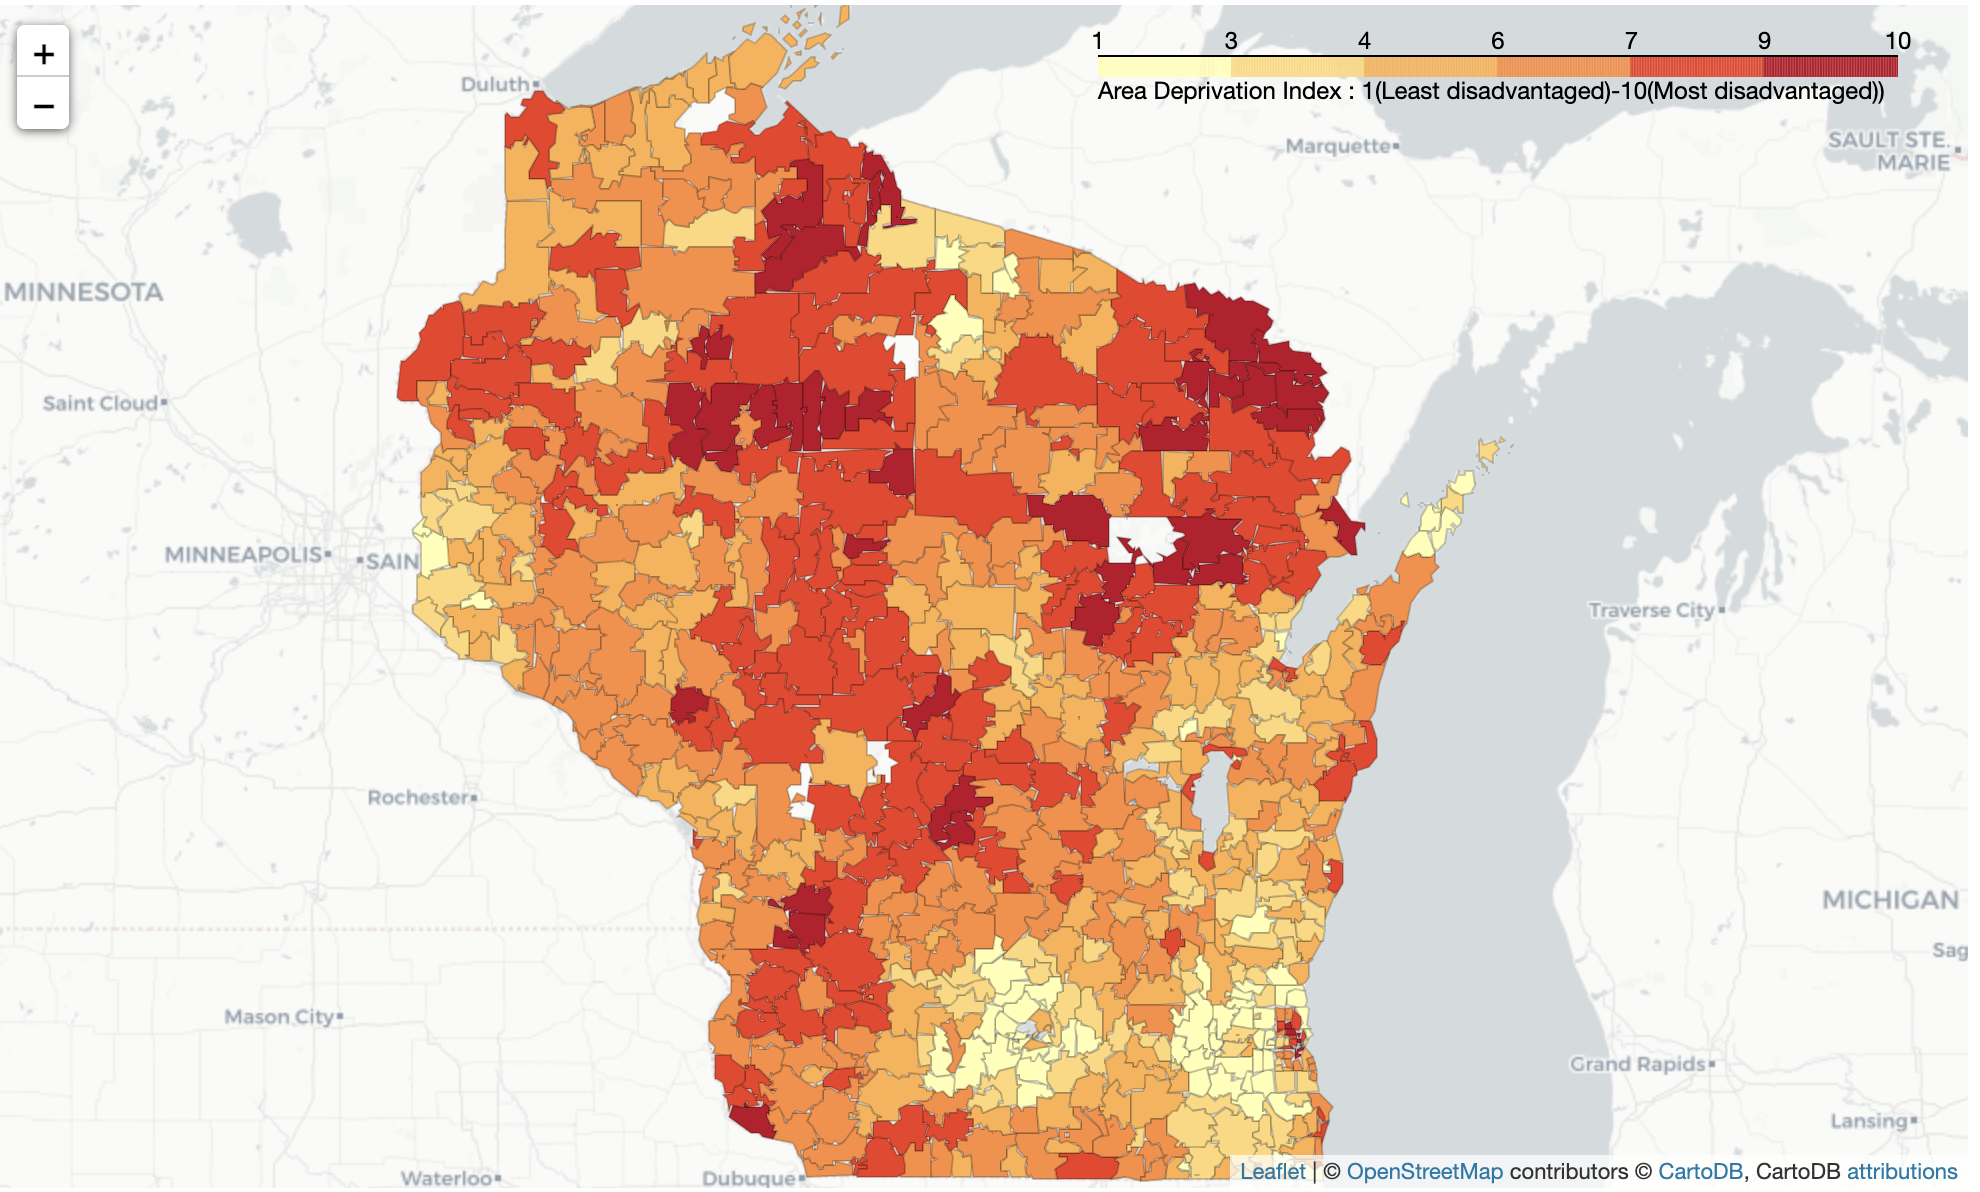

In [11]:
import folium
import pandas as pd
import json
import requests

# GeoJSON file definition
wisconsin_geojson = "https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wi_wisconsin_zip_codes_geo.min.json"


# Creating the map centered at Wisconsin state
m = folium.Map(location=[44.808444, -89.673194], 
               tiles="cartodbpositron", 
               zoom_start=6.8)

# Creating the Choropleth
m.choropleth(geo_data=json.loads(requests.get(wisconsin_geojson).text),
             data=df_clean,
             columns=['ZIP', 'ADI_STATERANK'],
             key_on='feature.properties.ZCTA5CE10', 
             fill_color='YlOrRd', fill_opacity=1, line_opacity=0.2,
             legend_name='Area Deprivation Index : 1(Least disadvantaged)-10(Most disadvantaged))')

m


In [12]:
m.save(outfile = './choropleth_wisconsin.html' )

### 4. Final thoughts of this dataset

Finally, let's reflect into the next questions before using this dataset for our Datadive event!
    - Is the zipcode the best neighborhood unit to match information from UWWisconsin calls?
    - Can we find another way to aggregate the scores (currently: average)?
    - Is this information enough to draw conclusions for our analysis? Do we need an additional socioeconomic dataset?
